# Deep Ensemble Models - Regression
This chapter aims to show a deep ensemble regression model defined in Pytorch from scratches.

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

## Regression Deep Ensemble model
This is an elementary implementation of a (Deep Ensemble) regression model in Pytorch.

First, we define the device (GPU/CPU) we are working with:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


The data frame is the linear relationship without noise introduced in step_1, we explicitly split the data frame into training/validation/test set.

In [3]:
chosen_df = "df_nonlinear_homoscedastic_aleatoric.csv"

full_df = pd.read_csv(os.path.join(path_data, chosen_df))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

full_df.head(8)

,x_range,y_range,split_label
0,-100.00000,-1.827437,0
1,-99.89995,-2.038570,0
2,-99.79990,-2.156036,2
3,-99.69985,-1.881278,2
4,-99.59980,-2.062530,0
5,-99.49975,-1.886184,1
6,-99.39970,-1.834947,0
7,-99.29965,-1.823319,0


We define a CustomDataset from Pytorch Dataset. The dataset has an *init* (initialise the class), a *len* and a *getitem* method.
A Dataset must provide the tools to identify available data and return all the elements needed to train/test/evaluate the model.

We modified the CustomDataset to take as input the percentage of data to be kept (for **Bagging**):

In [4]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, path_data, split_label=None, percentage = 1):
        if split_label!=None:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))
            self.df = self.df[self.df['split_label']==split_label]

            if percentage < 1:
                # Reshuffle the order of the dataset and sample a percentage of it:
                self.df = self.df.sample(frac=percentage)
        else:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))

            if percentage < 1:
                # Reshuffle the order of the dataset and sample a percentage of it:
                self.df = self.df.sample(frac=percentage)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_range = float(self.df.iloc[idx]['x_range'])
        y_range = float(self.df.iloc[idx]['y_range'])

        features = torch.tensor([x_range], dtype=torch.float32)
        output = torch.tensor([y_range], dtype=torch.float32)
        
        return features, output

To define an **Ensemble** we need to define a family of models. 

The standard ensemble is usually made up of models with slightly different properties to capture the uncertainties.

However, the theory behind the **Deep Ensambles** states that, given a fixed geometry, it is sufficient to change:
- The random initialization of the models (for sufficiently complex models)
- The order of the provided data (for sufficiently complex models)
- [**Bagging**] Select a subset of the whole dataset each time (for easier models)

In this example we are going to apply all the three procedures. Therefore we define a *list* of training dataset and corresponding *dataloader*:

In [5]:
# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0)
print("Length training dataset:", training_dataset.__len__())

index_example = 27
print(f"Output example (x_range,y_range)=({training_dataset.__getitem__(index_example)}) with index {index_example}.")

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=2)

# Define a list of submodels
n_models = 5
percentage = 0.9
list_training_dataset = []
# Remark: Validation and test are always the same

# Define multiple (reduced) version of the training dataset:
for i in range(n_models):
    # Select a subset dataset
    tmp_training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0, percentage=percentage)    
    list_training_dataset.append(tmp_training_dataset)    

Length training dataset: 1600
Output example (x_range,y_range)=((tensor([-96.3982]), tensor([-1.8095]))) with index 27.


To define a batch we can iterate on the whole dataset or define a *DataLoader* which samples from the introduced DataSet and can be iterated during training. It provides a batch of tensors to apply the computations efficiently at the same time.

This time we need a different dataloader for each custom training dataset:

In [6]:
# Size of each batch
batch_size = 10  

# Define 2 DataLoaders: Validation/Test 
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# The training dataloader are defined on the list_training_dataset:
list_training_dataloader = [DataLoader(i, batch_size=batch_size, shuffle=True) for i in list_training_dataset]

Introduce a the list of models to approximate the relationship:

In [7]:
list_models = []

for i in range(n_models):
    # Define the model:
    model = nn.Sequential(
        nn.Linear(1, 8),
        nn.ReLU(),
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 1)
    )
    
    # Move the model to device (GPU):
    model.to(device)
    
    # Convert weights type to float:
    model = model.float()

    # Append to the list:
    list_models.append(model)

Introduce the loss and the optimiser. Both can be implemented explicitly. The loss can be any function relating predictions and ground truths.

In [8]:
# Loss function (Mean Squared Error):
loss_fn = nn.MSELoss()  

# Optimizer (Adam): 
learning_rate = 1e-3

Training cycle: 
- The model is trained for a given number of epochs *n_epochs*
- Each epoch iterates over the entire dataset (*shuffle == True* just randomly shuffles indices) using the dataloader to generate batches.
- For each batch, the gradients are computed on the whole batch to the respect of the loss function and the optimizer it is used to update model trainable parameters


In [9]:
# Number of training epochs:
n_epochs = 30

training_loss_list_models = []
validation_loss_list_models = []

for index in range(n_models):
    print("\nModel index:", index)
    training_loss_list = []
    validation_loss_list = []
    
    tmp_model = list_models[index]
    tmp_training_dataloader = list_training_dataloader[index]
    
    optimizer = optim.Adam(tmp_model.parameters(), lr=learning_rate)
    
    # Iterate over the epochs:
    for epoch in range(n_epochs):
        # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
        list_models[index].train()  
    
        # Temporary variable to store the loss on the whole epoch as a convergence metric
        running_loss = 0.0
    
        # Iterate on the whole dataset using the dataloader.
        for x_input, y_output in tmp_training_dataloader:
            # Load inputs ad move to device (GPU)
            x_input, y_output = x_input.to(device), y_output.to(device)
    
            # Clear previous gradients
            optimizer.zero_grad()  
            
            # Forward pass (model calls)
            y_model = tmp_model(x_input)  
    
            # Compute loss (supervised case)
            loss = loss_fn(y_model, y_output)  
            
            # Backpropagation 
            loss.backward()  
    
            # Update parameters (optimization step)
            optimizer.step()  
    
            # Update running loss as convergence metric
            running_loss += loss.item()
            
    
        
        ## Calculate loss on validation as an additional metric to evaluate overfitting
        # Set the model to Evaluation mode:
        list_models[index].eval()
    
        # Temporary variable to store the validation loss:
        running_val_loss = 0.0
        
        # Deactivate gradient computation
        with torch.no_grad():
            for x_input, y_output in validation_dataloader:
                # Load inputs ad move to device (GPU)
                x_input, y_output = x_input.to(device), y_output.to(device)
            
                # Forward pass (model calls)
                y_model = tmp_model(x_input)
    
                # Compute loss (supervised case)
                loss = loss_fn(y_model, y_output)
    
                # Update validation running loss as convergence metric
                running_val_loss += loss.item()
                
        # Average epoch loss
        epoch_training_loss = running_loss / len(tmp_training_dataloader)
        epoch_validation_loss = running_val_loss / len(validation_dataloader)
    
        # Append the losses to the list:
        training_loss_list.append(epoch_training_loss)
        validation_loss_list.append(epoch_validation_loss)
                
        # Convergence metric
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")
        
    training_loss_list_models.append(training_loss_list)
    validation_loss_list_models.append(validation_loss_list)


Model index: 0
Epoch [1/30], Loss: 0.6266, Val. Loss: 0.3900
Epoch [2/30], Loss: 0.3833, Val. Loss: 0.3431
Epoch [3/30], Loss: 0.2998, Val. Loss: 0.2134
Epoch [4/30], Loss: 0.1956, Val. Loss: 0.2340
Epoch [5/30], Loss: 0.1496, Val. Loss: 0.0986
Epoch [6/30], Loss: 0.1026, Val. Loss: 0.0844
Epoch [7/30], Loss: 0.0946, Val. Loss: 0.0822
Epoch [8/30], Loss: 0.0866, Val. Loss: 0.0757
Epoch [9/30], Loss: 0.0873, Val. Loss: 0.0959
Epoch [10/30], Loss: 0.0844, Val. Loss: 0.0682
Epoch [11/30], Loss: 0.0820, Val. Loss: 0.0691
Epoch [12/30], Loss: 0.0823, Val. Loss: 0.0715
Epoch [13/30], Loss: 0.0776, Val. Loss: 0.0662
Epoch [14/30], Loss: 0.0760, Val. Loss: 0.0683
Epoch [15/30], Loss: 0.0743, Val. Loss: 0.0744
Epoch [16/30], Loss: 0.0761, Val. Loss: 0.0804
Epoch [17/30], Loss: 0.0718, Val. Loss: 0.0879
Epoch [18/30], Loss: 0.0722, Val. Loss: 0.0662
Epoch [19/30], Loss: 0.0654, Val. Loss: 0.0617
Epoch [20/30], Loss: 0.0668, Val. Loss: 0.0525
Epoch [21/30], Loss: 0.0599, Val. Loss: 0.0567
Epoch 

Plot the convergence graphs on training and validation sets:

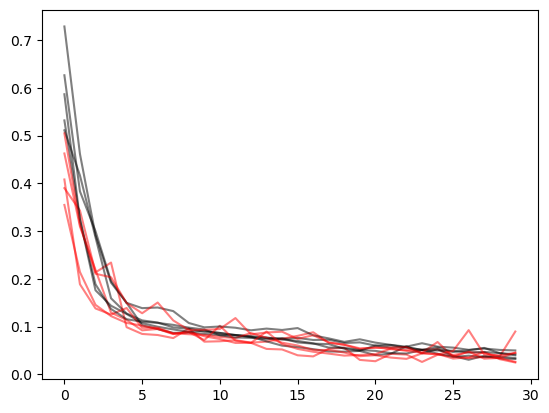

In [10]:
fig, ax = plt.subplots()

for index in range(n_models):
    ax.plot(list(range(len(training_loss_list_models[index]))), training_loss_list_models[index], color = 'black', alpha = 0.5)
    ax.plot(list(range(len(validation_loss_list_models[index]))), validation_loss_list_models[index],  color = 'red', alpha = 0.5)

Plot the training dataset against the predictions:

<Axes: xlabel='x', ylabel='y'>

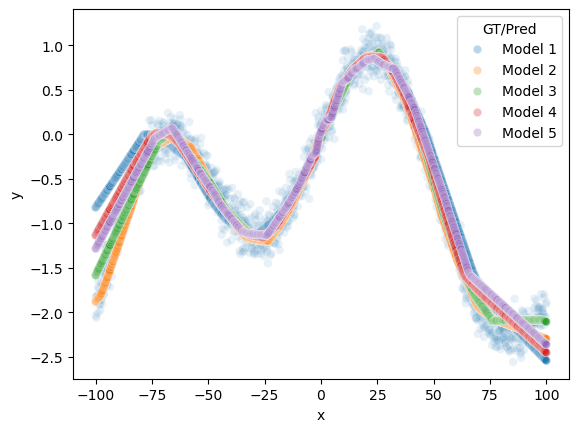

In [18]:
# Define the dataframe 
x_plot = np.array(training_df["x_range"])  # Input
y_plot = np.array(training_df["y_range"])  # Ground Truth

# Collect predictions from all models
list_prediction_plot = []

# Loop through each model and make predictions
for model in list_models:
    model_predictions = [float(model(torch.tensor(i).view(1).to(device).float()).to('cpu')) for i in x_plot]
    list_prediction_plot.append(model_predictions)

# Flatten the predictions and add model identifiers
x_stacked = np.tile(x_plot, n_models)  # Repeat x_plot for each model
y_stacked = np.concatenate(list_prediction_plot)  # Flatten the list of predictions
model_labels = np.concatenate([[f"Model {i+1}"] * len(x_plot) for i in range(n_models)])

# Create a DataFrame for Predictions
df_plot_pred = pd.DataFrame({
    "x": x_stacked,   # x-values for all models
    "y": y_stacked,   # Predictions
    "GT/Pred": model_labels  # Model labels
})

# Create a DataFrame for Ground Truth
df_plot_gt = pd.DataFrame({
    "x": x_plot, 
    "y": y_plot, 
    "GT/Pred": ["GT"] * len(y_plot)
})


# Plot Ground Truth
sns.scatterplot(data=df_plot_gt, x="x", y="y", hue="GT/Pred", alpha=0.1, legend=False)

# Plot Predictions 
sns.scatterplot(data=df_plot_pred, x="x", y="y", hue="GT/Pred", alpha=0.3)

Now that we have multiple predictions, each time that we make inference, we need to compute the prediction of the Ensemble. The prediction is the mean of the *n_models* predictions and the reliability is a function of the std computed. For a reduced number of models, another possibility is the median and the IQR range. Plot the Deep Ensemble prediction and a measure of reliability ($2 \cdots \text{std}$):

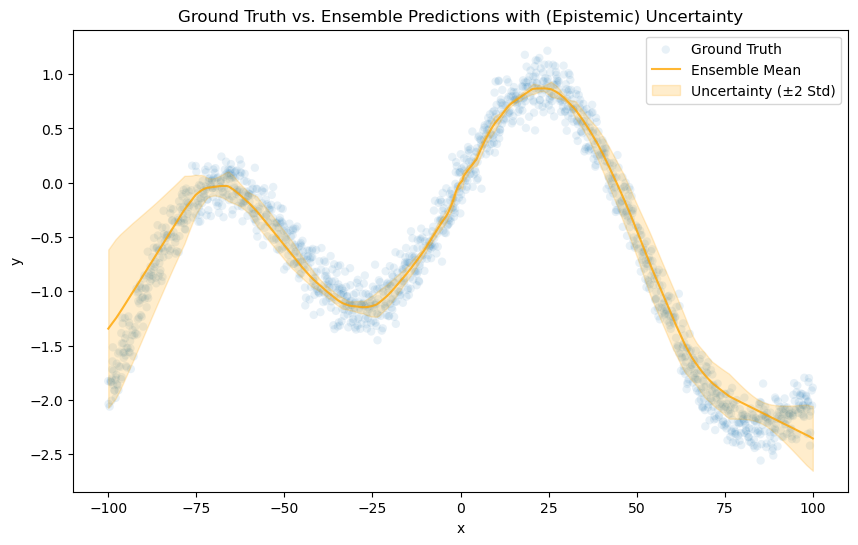

In [25]:
# Compute the ensemble mean and standard deviation
list_Ensemble_predictions = np.mean(list_prediction_plot, axis=0)   # Mean prediction
list_Ensemble_std = np.std(list_prediction_plot, axis=0)            # Standard deviation


# Create a DataFrame for Ensemble Predictions
df_plot_ensemble = pd.DataFrame({
    "x": x_plot, 
    "y": list_Ensemble_predictions,  # Mean predictions
    "y_lower": list_Ensemble_predictions - 2 * list_Ensemble_std,  # -2 std
    "y_upper": list_Ensemble_predictions + 2 * list_Ensemble_std,  # +2 std
    "GT/Pred": ["Ensemble"] * len(y_plot)
})

# Create a DataFrame for Ground Truth
df_plot_gt = pd.DataFrame({
    "x": x_plot, 
    "y": y_plot, 
    "GT/Pred": ["GT"] * len(y_plot)
})

# Plot Ground Truth
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot_gt, x="x", y="y", hue="GT/Pred", alpha=0.1, legend=False, label="Ground Truth")

# Plot Ensemble Mean Line
sns.lineplot(data=df_plot_ensemble, x="x", y="y", color="orange", label="Ensemble Mean", alpha = 0.8)

# Fill Between ±2 Std Dev
plt.fill_between(df_plot_ensemble["x"], df_plot_ensemble["y_lower"], df_plot_ensemble["y_upper"], 
                 color="orange", alpha=0.2, label="Uncertainty (±2 Std)")

# Labels and Title
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ground Truth vs. Ensemble Predictions with (Epistemic) Uncertainty")
plt.legend()
plt.show()

The Deep Ensemble behaves as expected. Even if the whole dataset is contaminated with (Aleatoric) uncertainty, the Deep Ensemble is able to provide a better estimate of the epistemic uncertainty. In fact, the model correctly identifies as "less reliable" predictions at the boundaries of the training support, while being coherent and stable in the inner part of the dataset.